# Batch correction

## Motivation

As could be seen for our earlier visualized ADT data, batch effects between samples are very pronounced.
Hence, batch correction to mitigate this effect is required.
Generally, no purpose build methods for the batch correction of ADT data have been developed, and we therefore suggest applying methods designed for transcriptomics data to ADT data.

## Environment setup

In [1]:
import scanpy as sc
import muon as mu
import numpy as np
import seaborn as sns
import harmonypy as hm
import warnings

warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

/home/icb/daniel.strobl/conda21/envs/surface-protein/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data

In [2]:
filtered_xdbt_mu_path = "/lustre/groups/ml01/workspace/ciro.suastegui/bp2.0/data/neurips_cite_pp_filtered-qc-norm-xdbt.h5mu"

In [3]:
filtered = mu.read(filtered_xdbt_mu_path)

It is not yet clear which batch effect correction works best for ADT data. For general purposes we recommend scVI {cite}`sp:Lopez2018` or Harmony {cite}`Korsunsky2019` to perform batch correction of the data due to their robust performance on scRNA-seq data.

## Harmony

In [4]:
%%time
ho = hm.run_harmony(filtered["prot"].X, filtered["prot"].obs, ["donor"])

2023-02-03 15:07:03,371 - harmonypy - INFO - Iteration 1 of 10
2023-02-03 15:08:18,164 - harmonypy - INFO - Iteration 2 of 10
2023-02-03 15:09:32,771 - harmonypy - INFO - Iteration 3 of 10
2023-02-03 15:10:47,929 - harmonypy - INFO - Iteration 4 of 10
2023-02-03 15:11:59,638 - harmonypy - INFO - Iteration 5 of 10
2023-02-03 15:12:44,865 - harmonypy - INFO - Iteration 6 of 10
2023-02-03 15:13:22,069 - harmonypy - INFO - Iteration 7 of 10
2023-02-03 15:13:56,532 - harmonypy - INFO - Iteration 8 of 10
2023-02-03 15:14:31,102 - harmonypy - INFO - Converged after 8 iterations


CPU times: user 1h 20min 16s, sys: 1h 25min 24s, total: 2h 45min 40s
Wall time: 9min 11s


In [5]:
pc_std = np.std(ho.Z_corr, axis=1).tolist()

<AxesSubplot: >

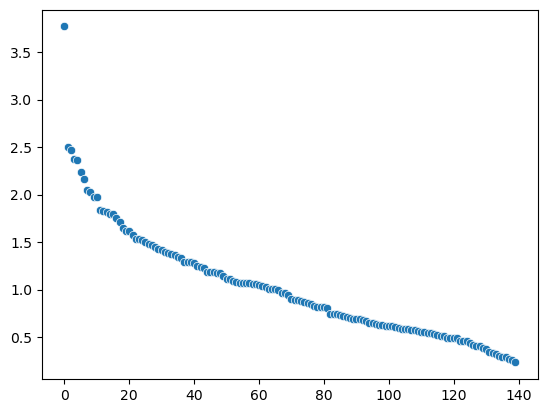

In [6]:
sns.scatterplot(x=range(0, len(pc_std)), y=sorted(pc_std, reverse=True))

In [7]:
filtered["prot"].obsm["X_pcahm"] = ho.Z_corr.transpose()

In [8]:
filtered["prot"].obsm

AxisArrays with keys: X_pcahm

In [9]:
%%time
sc.pp.neighbors(filtered["prot"], n_pcs=30, use_rep="X_pcahm")
sc.tl.umap(filtered["prot"])

CPU times: user 5min 17s, sys: 2min 9s, total: 7min 26s
Wall time: 2min 33s


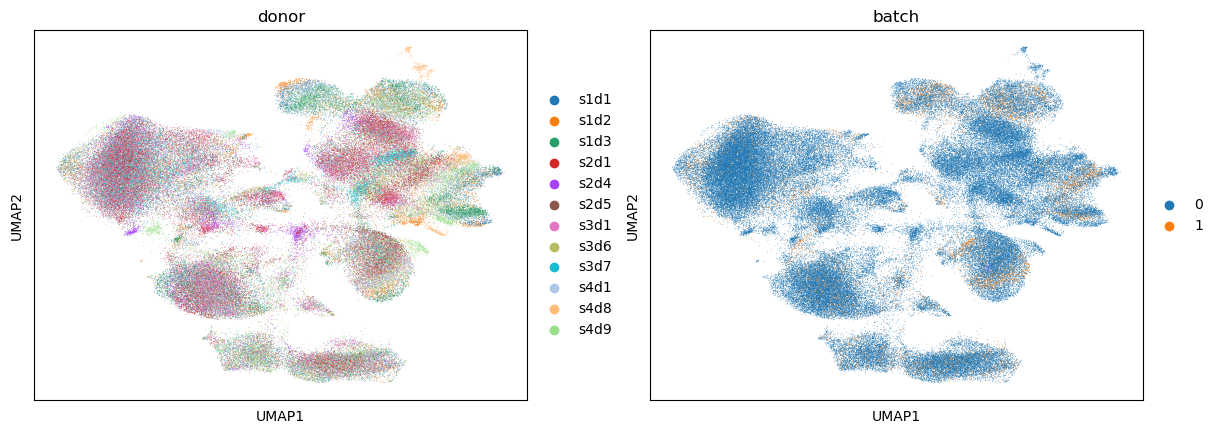

In [11]:
sc.pl.umap(filtered["prot"], color=["donor", "batch"])

As we can see here, the cells of different donors are much more intermixed in the embedding than before.

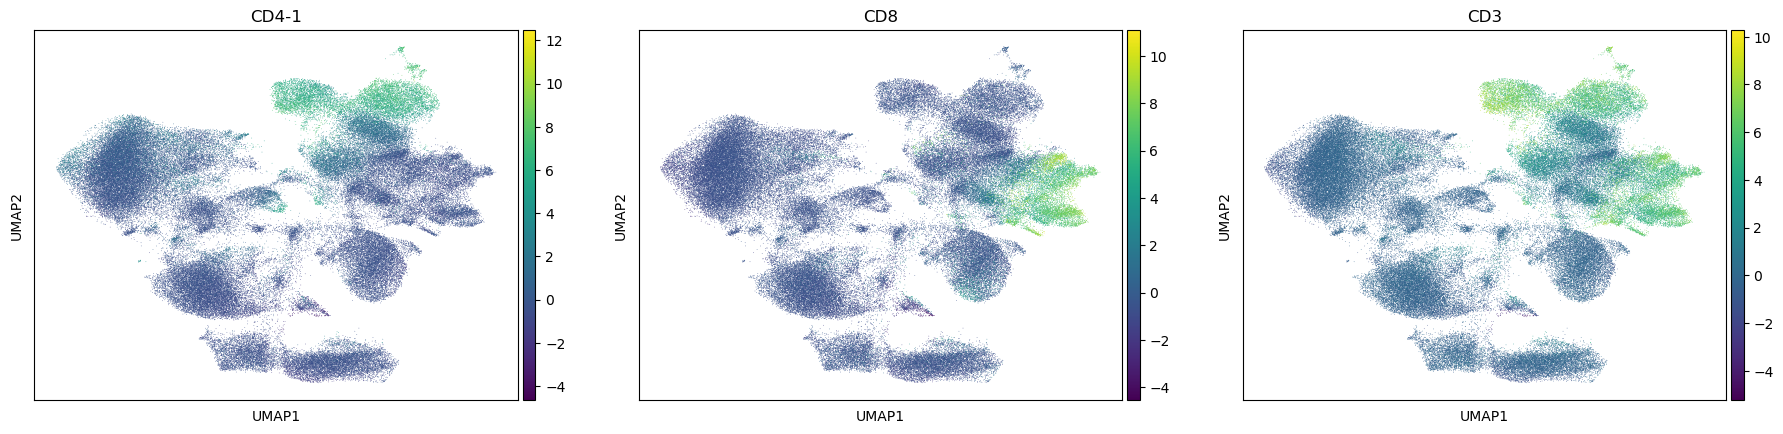

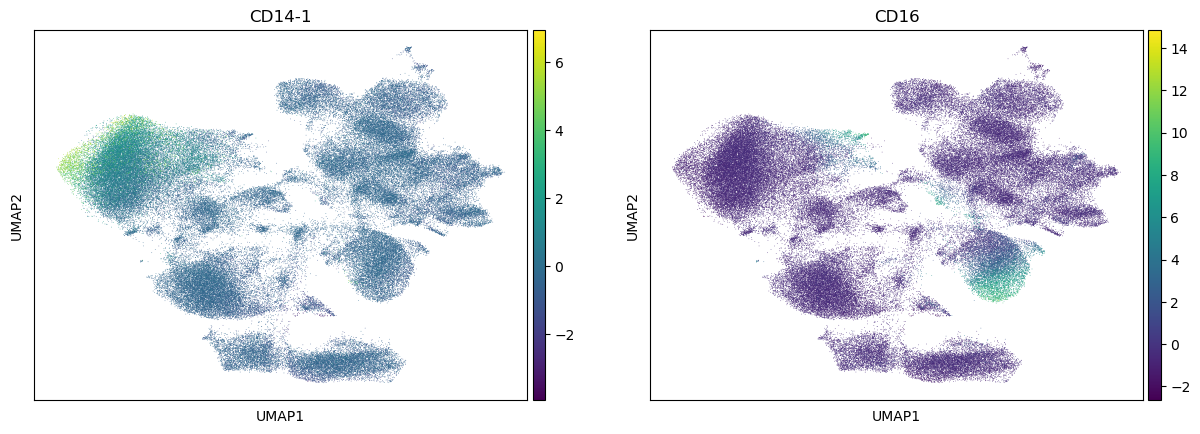

In [12]:
sc.pl.umap(filtered["prot"], color=["CD4-1", "CD8", "CD3"])
sc.pl.umap(filtered["prot"], color=["CD14-1", "CD16"])

We check the expression of a few marker genes to confirm that separate cell types are still separate from each other. We can see that T cells still form a separate population that is further split into CD4 and CD8 T cells.

In following steps, you can now go ahead and cluster and annotate the cells in a similar process as it is described in the annotation chapter[LINK].
Here, we have only used the ADT part of the data and thus lost all of the information contained in the RNA part of the study.
In other chapters, we will explore how you can make use of both modalities jointly, which allows for a more detailed cell type annotation for example.

## Key takeaways

TODO

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: sp
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Daniel Strobl
* Ciro Ramírez-Suástegui

### Reviewers

* Lukas Heumos